In [132]:
import pandas as pd
import numpy as np
import keras
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import random
import pickle
from keras import models, layers, callbacks
import shutil
import cv2
from math import sqrt, floor
from prettytable import PrettyTable

In [133]:
def print_bold(text):
    print('\033[1m{}\033[0m'.format(text))

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        
        dir_name= '{}{}/'.format(indent, os.path.basename(root))
        if dir_name.strip().startswith('.'):
            continue
        
        print_bold('\n'+dir_name)
            
        subindent = ' ' * 4 * (level + 1)
        if level==0:
            for f in files:
                if f.startswith('.'):
                    continue
                print('{}{}'.format(subindent, f))
        else:
            #if len(files)>0:
            #   print('{}File Count: {}'.format(subindent, len(files)))
            for i, f in enumerate(files):
                print('{}{}'.format(subindent, f))
                if i==2:
                    print('{}{}'.format(subindent, '...'))
                    break

list_files(os.getcwd())


adam1/
    adam2.ipynb
    adamtest.ipynb
    adam_final.ipynb

    test/

        test_images/
            00_1.png
            00_10.png
            00_100.png
            ...

    train/

        Black-grass/
            00_00_1.png
            00_00_10.png
            00_00_100.png
            ...

        Charlock/
            01_01_1.png
            01_01_100.png
            01_01_103.png
            ...

        Cleavers/
            02_02_1.png
            02_02_100.png
            02_02_101.png
            ...

        Common Chickweed/
            03_03_1.png
            03_03_10.png
            03_03_100.png
            ...

        Common wheat/
            04_04_1.png
            04_04_10.png
            04_04_100.png
            ...

        Fat Hen/
            05_05_1.png
            05_05_10.png
            05_05_100.png
            ...

        Loose Silky-bent/
            06_06_1.png
            06_06_10.png
            06_06_100.png
            ...

        Maize/

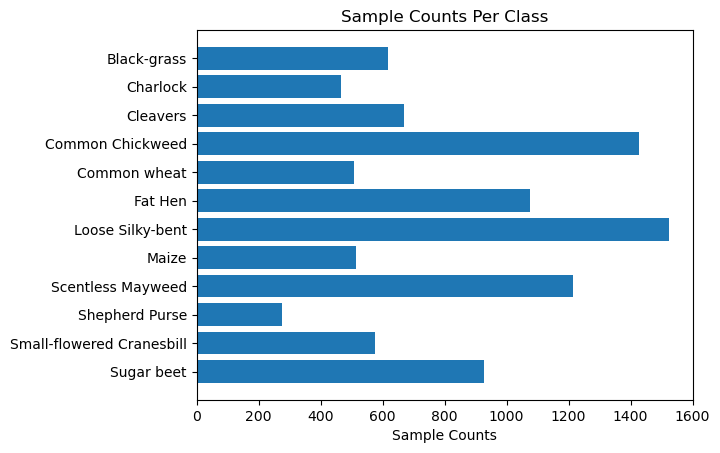

In [134]:
classes= []
sample_counts= []

for f in os.listdir('train'):
    train_class_path= os.path.join('train', f)
    if os.path.isdir(train_class_path):
        classes.append(f)
        sample_counts.append(len(os.listdir(train_class_path)))

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(classes))

ax.barh(y_pos, sample_counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(classes)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sample Counts')
ax.set_title('Sample Counts Per Class')

plt.show()

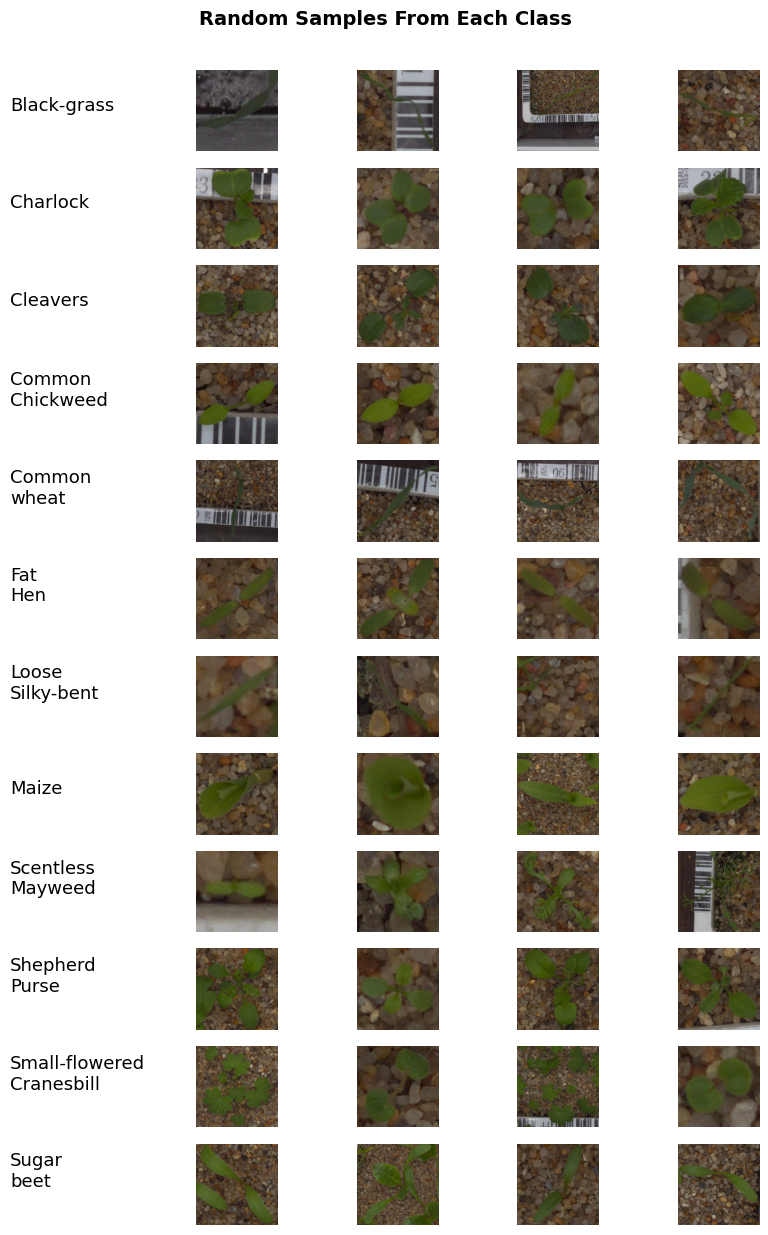

In [135]:
fig= plt.figure(figsize= (10, 15))
fig.suptitle('Random Samples From Each Class', fontsize=14, y=.92, horizontalalignment='center', weight='bold')

columns = 5
rows = 12
for i in range(12):
    sample_class= os.path.join('train',classes[i])
    for j in range(1,6):
        fig.add_subplot(rows, columns, i*5+j)
        plt.axis('off')
        if j==1:
            plt.text(0.0, 0.5,str(classes[i]).replace(' ','\n'), fontsize=13, wrap=True)
            continue
        random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
        #from keras.preprocessing.image
        img = image.load_img(random_image, target_size=(150, 150))
        img= image.img_to_array(img)
        img/=255.
        plt.imshow(img)
        
        

plt.show()

In [136]:
#create validation set
def create_validation(validation_split=0.2):
    if os.path.isdir('validation'):
        print('Validation directory already created!')
        print('Process Terminated')
        return
    os.mkdir('validation')
    for f in os.listdir('train'):
        train_class_path= os.path.join('train', f)
        if os.path.isdir(train_class_path):
            validation_class_path= os.path.join('validation', f)
            os.mkdir(validation_class_path)
            files_to_move= int(0.2*len(os.listdir(train_class_path)))
            
            for i in range(files_to_move):
                random_image= os.path.join(train_class_path, random.choice(os.listdir(train_class_path)))
                shutil.move(random_image, validation_class_path)
    print('Validation set created successfully using {:.2%} of training data'.format(validation_split))

In [137]:
create_validation()

Validation set created successfully using 20.00% of training data


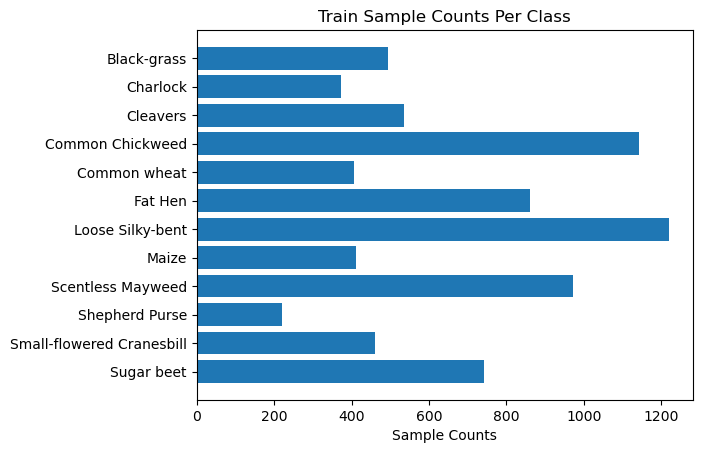

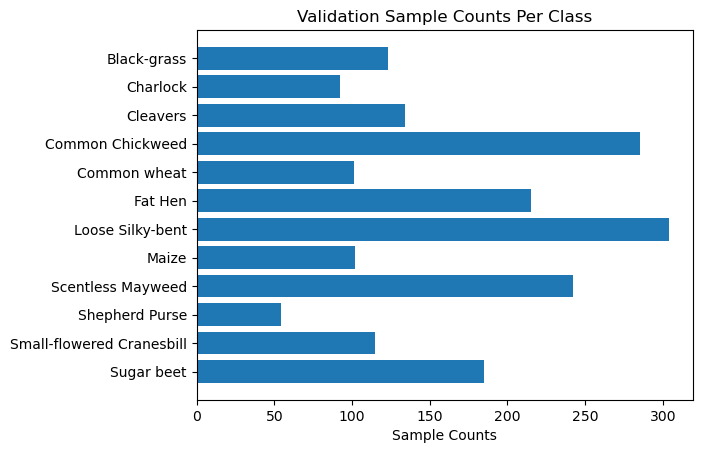

In [138]:
sample_counts= {}

for i, d in enumerate(['train', 'validation']):

    classes= []
    sample_counts[d]= []

    for f in os.listdir(d):
        train_class_path= os.path.join(d, f)
        if os.path.isdir(train_class_path):
            classes.append(f)
            sample_counts[d].append(len(os.listdir(train_class_path)))

    #fig, ax= plt.subplot(221+i)
    fig, ax = plt.subplots()

    # Example data
    y_pos = np.arange(len(classes))

    ax.barh(y_pos, sample_counts[d], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(classes)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Sample Counts')
    ax.set_title('{} Sample Counts Per Class'.format(d.capitalize()))

plt.show()

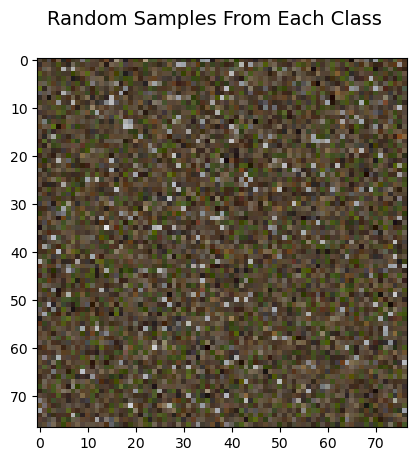

In [139]:
def pull_random_pixels(samples_per_class, pixels_per_sample):
    total_pixels= 12*samples_per_class*pixels_per_sample
    random_pixels= np.zeros((total_pixels, 3), dtype=np.uint8)
    for i in range(12):
        sample_class= os.path.join('train',classes[i])
        for j in range(samples_per_class):
            
            random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
            img= cv2.imread(random_image)
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img=np.reshape(img, (img.shape[0]*img.shape[1], 3))
            new_pixels= img[np.random.randint(0, img.shape[0], pixels_per_sample)]
            
            start_index=pixels_per_sample*(i*samples_per_class+j)
            random_pixels[start_index:start_index+pixels_per_sample,:]= new_pixels

    h= floor(sqrt(total_pixels))
    w= total_pixels//h
    
    random_pixels= random_pixels[np.random.choice(total_pixels, h*w, replace=False)]
    random_pixels= np.reshape(random_pixels, (h, w, 3))
    return random_pixels
    
random_pixels= pull_random_pixels(10r̥, 50)

plt.figure()
plt.suptitle('Random Samples From Each Class', fontsize=14, horizontalalignment='center')
plt.imshow(random_pixels)
plt.show()

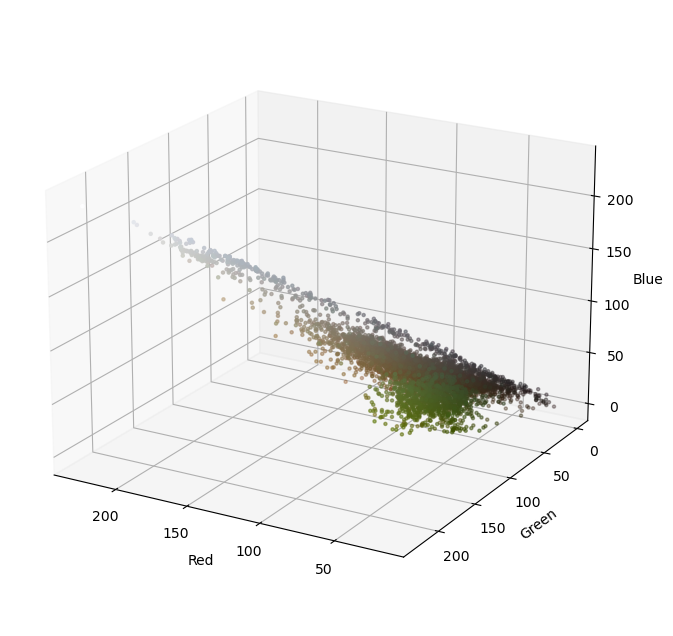

In [140]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

r, g, b = cv2.split(random_pixels)
fig = plt.figure(figsize=(8, 8))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.view_init(20, 120)

pixel_colors = random_pixels.reshape((np.shape(random_pixels)[0]*np.shape(random_pixels)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()


axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

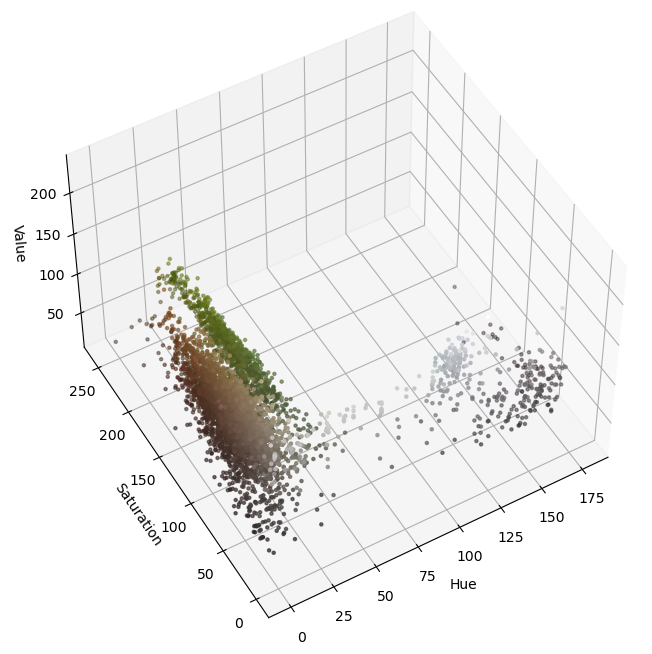

In [141]:
hsv_img = cv2.cvtColor(np.uint8(random_pixels), cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_img)
fig = plt.figure(figsize=(8,8))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.view_init(50, 240)



axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

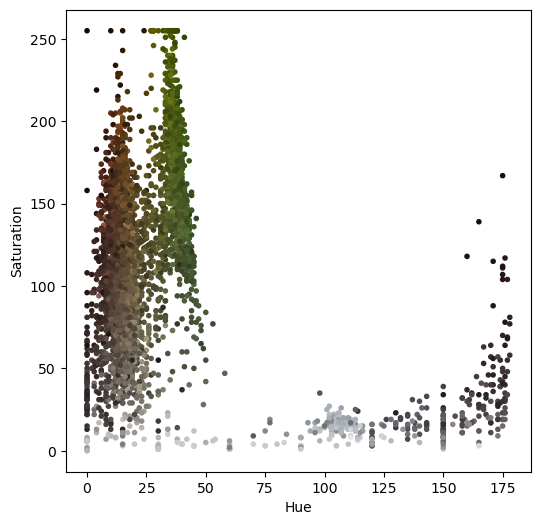

In [142]:
hsv_img = cv2.cvtColor(np.uint8(random_pixels), cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_img)
fig = plt.figure(figsize=(6,6))
axis = fig.add_subplot(1, 1, 1)

axis.scatter(h.flatten(), s.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
plt.show()

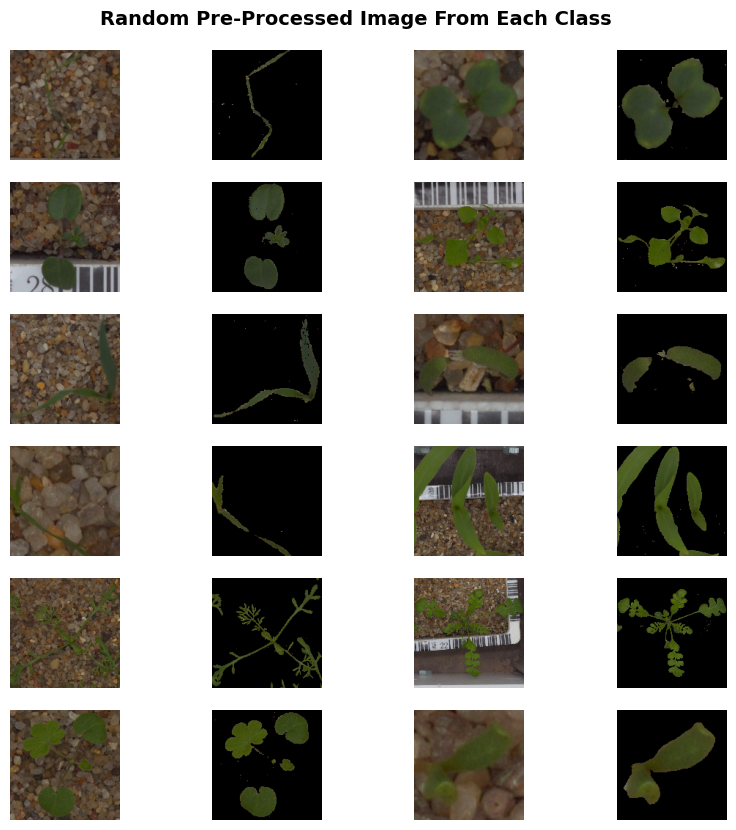

In [143]:
lower_bound= (24, 50, 0)
upper_bound= (55, 255, 255)

fig= plt.figure(figsize=(10, 10))
fig.suptitle('Random Pre-Processed Image From Each Class', fontsize=14, y=.92, horizontalalignment='center', weight='bold')

for i in range(12):
    sample_class=os.path.join('train',classes[i])
    random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
    img= cv2.imread(random_image)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, (150, 150))
    
    hsv_img= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, lower_bound, upper_bound)
    result = cv2.bitwise_and(img, img, mask=mask)

    fig.add_subplot(6, 4, i*2+1)
    plt.imshow(img)
    plt.axis('off')    

    fig.add_subplot(6, 4, i*2+2)
    plt.imshow(result)
    plt.axis('off')
    
plt.show()

In [144]:
def color_segment_function(img_array):
    img_array= np.rint(img_array)
    img_array= img_array.astype('uint8')
    hsv_img= cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, (24, 50, 0), (55, 255, 255))
    result = cv2.bitwise_and(img_array, img_array, mask=mask)
    result= result.astype('float64')
    return result

In [145]:
#image function from keras.preprocessing
train_datagen = image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.0,
      height_shift_range=0.0,
      shear_range=0.0,
      zoom_range=0.0,
      horizontal_flip=True,
      vertical_flip= True,
    preprocessing_function=color_segment_function,
      fill_mode='nearest')

test_datagen = image.ImageDataGenerator(rescale=1./255, preprocessing_function=color_segment_function)

In [146]:
train_generator = train_datagen.flow_from_directory(
  'train',
  target_size=(150, 150),
  batch_size=20,
  class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(150,150),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

Found 7836 images belonging to 12 classes.
Found 1952 images belonging to 12 classes.
Found 5319 images belonging to 1 classes.


In [147]:
#get class indices and labels. calculate class weight
label_map = {}
for k, v in train_generator.class_indices.items():
    label_map[v]=k

class_counts= pd.Series(train_generator.classes).value_counts()
class_weight= {}

for i, c in class_counts.items():
    class_weight[i]= 1.0/c
    
norm_factor= np.mean(list(class_weight.values()))

for k in class_counts.keys():
    class_weight[k]= class_weight[k]/norm_factor

t = PrettyTable(['class_index', 'class_label', 'class_weight'])
for i in sorted(class_weight.keys()):
    t.add_row([i, label_map[i], '{:.2f}'.format(class_weight[i])])
print(t)

+-------------+---------------------------+--------------+
| class_index |        class_label        | class_weight |
+-------------+---------------------------+--------------+
|      0      |        Black-grass        |     1.04     |
|      1      |          Charlock         |     1.38     |
|      2      |          Cleavers         |     0.96     |
|      3      |      Common Chickweed     |     0.45     |
|      4      |        Common wheat       |     1.27     |
|      5      |          Fat Hen          |     0.60     |
|      6      |      Loose Silky-bent     |     0.42     |
|      7      |           Maize           |     1.24     |
|      8      |     Scentless Mayweed     |     0.53     |
|      9      |       Shepherd Purse      |     2.33     |
|      10     | Small-flowered Cranesbill |     1.11     |
|      11     |         Sugar beet        |     0.69     |
+-------------+---------------------------+--------------+


In [148]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))



model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(12, activation='softmax'))

In [149]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)      

In [150]:
best_cb= callbacks.ModelCheckpoint('model_best.h5', 
#                                          monitor='val_loss', 
                                         verbose=1, 
                                         save_best_only=True, 
                                         save_weights_only=False, 
#                                          mode='auto'
                                  
                                  ) 
                                        
opt= keras.optimizers.Adam(lr=0.0005, amsgrad=True)

In [151]:
model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [152]:
history = model.fit(
                    train_generator,
                    class_weight= class_weight,
#                      steps_per_epoch= 137,
                    epochs=50,
#                     batch_size=20,
                    validation_data=validation_generator,
#                     validation_steps= 33,
                    verbose=1,
                    callbacks= [best_cb])
print(history.history)
print(model.metrics_names)

Epoch 1/50
392/392 [==============================] - ETA: 0s - loss: 1.2873 - accuracy: 0.4108
Epoch 00001: val_loss improved from inf to 1.13016, saving model to model_best.h5
392/392 [==============================] - 229s 584ms/step - loss: 1.2873 - accuracy: 0.4108 - val_loss: 1.1302 - val_accuracy: 0.5820
Epoch 2/50
392/392 [==============================] - ETA: 0s - loss: 0.8001 - accuracy: 0.6447
Epoch 00002: val_loss improved from 1.13016 to 0.75068, saving model to model_best.h5
392/392 [==============================] - 246s 627ms/step - loss: 0.8001 - accuracy: 0.6447 - val_loss: 0.7507 - val_accuracy: 0.7628
Epoch 3/50
392/392 [==============================] - ETA: 0s - loss: 0.6596 - accuracy: 0.6905
Epoch 00003: val_loss improved from 0.75068 to 0.65251, saving model to model_best.h5
392/392 [==============================] - 244s 623ms/step - loss: 0.6596 - accuracy: 0.6905 - val_loss: 0.6525 - val_accuracy: 0.7838
Epoch 4/50
392/392 [==============================] -

Epoch 28/50
392/392 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.8825
Epoch 00028: val_loss did not improve from 0.21219
392/392 [==============================] - 248s 631ms/step - loss: 0.2268 - accuracy: 0.8825 - val_loss: 0.2784 - val_accuracy: 0.8765
Epoch 29/50
392/392 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.8857
Epoch 00029: val_loss did not improve from 0.21219
392/392 [==============================] - 240s 611ms/step - loss: 0.2206 - accuracy: 0.8857 - val_loss: 0.2653 - val_accuracy: 0.8770
Epoch 30/50
392/392 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.8883
Epoch 00030: val_loss did not improve from 0.21219
392/392 [==============================] - 238s 608ms/step - loss: 0.1986 - accuracy: 0.8883 - val_loss: 0.2309 - val_accuracy: 0.9068
Epoch 31/50
392/392 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.8903
Epoch 00031: val_loss improved from 0.21219 to 0.20846

In [153]:
#load best model from training
model= models.load_model('model_best.h5')

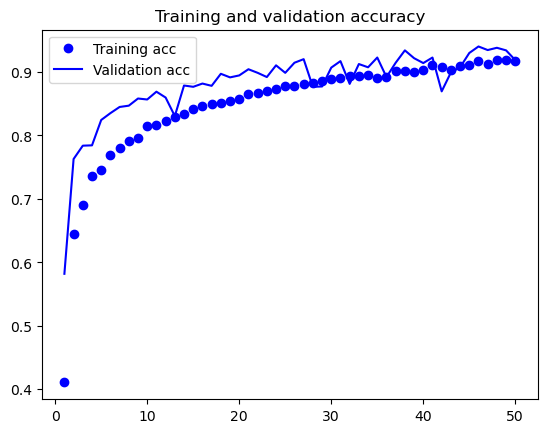

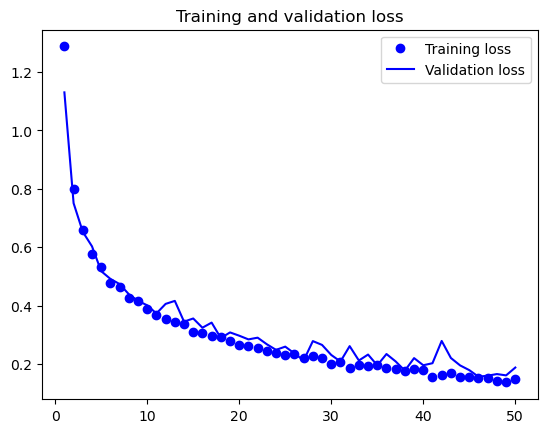

In [154]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [155]:
pred= model.predict_generator(test_generator, steps= test_generator.n, verbose=1)

5319/5319 [==============================] - 147s 28ms/step


In [156]:
predicted_class_indices=np.argmax(pred,axis=1)

prediction_labels = [label_map[k] for k in predicted_class_indices]
filenames= test_generator.filenames

In [157]:
import csv
csvfile= open('prediction.csv', 'w', newline='')
writer= csv.writer(csvfile)

headers= ['file', 'species']

writer.writerow(headers)
t = PrettyTable(headers)
for i, f, p in zip(range(len(filenames)), filenames, prediction_labels):
    writer.writerow([os.path.basename(f),p])
    if i <10:
        t.add_row([os.path.basename(f), p])
    elif i<13:
        t.add_row(['.', '.'])
csvfile.close()
print(t)

+------------+------------------+
|    file    |     species      |
+------------+------------------+
|  00_1.png  |   Black-grass    |
| 00_10.png  |   Black-grass    |
| 00_100.png |   Black-grass    |
| 00_101.png |   Black-grass    |
| 00_102.png |   Black-grass    |
| 00_103.png |   Black-grass    |
| 00_104.png |   Black-grass    |
| 00_105.png |   Black-grass    |
| 00_106.png |   Black-grass    |
| 00_107.png | Loose Silky-bent |
|     .      |        .         |
|     .      |        .         |
|     .      |        .         |
+------------+------------------+
